In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cryptovision.tools import (
    CryptoVisionAI, 
    image_directory_to_pandas, 
    split_image_dataframe, 
    tf_dataset_from_pandas
)

2024-12-23 11:47:28.619 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
IMAGES_DATASET_PATH = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset'
TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras'

SEED = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15
BATCH_SIZE = 64

df_images = image_directory_to_pandas(IMAGES_DATASET_PATH)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    random_state=SEED,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

# Instantiate the class
ai = CryptoVisionAI(
    model_path=TRAINED_MODEL_PATH,
    family_names=family_labels,
    genus_names=genus_labels,
    species_names=species_labels,
)

test_ds, _, _, _ = tf_dataset_from_pandas(
    test_df, batch_size=BATCH_SIZE, image_size=ai.input_size, shuffle=False)


2024-12-23 11:47:37.527970: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-23 11:47:37.527994: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-23 11:47:37.527998: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-23 11:47:37.528010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-23 11:47:37.528019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has

In [7]:
feature_extractor = tf.keras.Model(
    inputs=ai.model.input, 
    outputs=ai.model.get_layer('global_average_pooling2d').output
)


In [10]:
pred = ai.predict(test_df['image_path'].values[1])

pred

('Pomacanthidae', 'Centropyge', 'Centropyge flavissima')

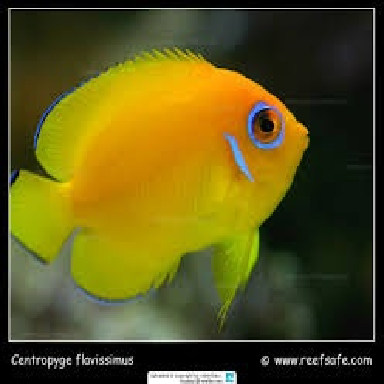

In [11]:
ai.image

In [18]:
features = feature_extractor.predict(ai.image_array, verbose=0)
features_vector = features.flatten()

In [64]:
class_features = {}

for row in test_df.itertuples():
   
    # Extract features for all images in the batch
    image_array = ai.load_image(row.image_path)
   
    features = feature_extractor.predict(image_array, verbose=0)
    features_vector = features.flatten()
    
    full_name = f'{row.family} {row.species}'
    
    if full_name not in class_features:
        class_features[full_name] = []
        
    class_features[full_name].append(features_vector)
    
    

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Compute Class-Level Feature Vectors (Averaging)
class_avg_features = {
    cls: np.mean(features, axis=0) for cls, features in class_features.items()
}

# Compute Cosine Similarity Between Classes
class_names = list(class_avg_features.keys())
feature_matrix = np.array([class_avg_features[cls] for cls in class_names])

similarity_matrix = cosine_similarity(feature_matrix)

# Display Similarity Matrix
import pandas as pd

df_similarity = pd.DataFrame(similarity_matrix, index=class_names, columns=class_names)

df_similarity.head()

,Tetraodontidae Canthigaster solandri,Pomacanthidae Centropyge flavissima,Gobiidae Gobiodon histrio,Pomacentridae Pomacentrus pavo,Gobiidae Paragobiodon lacunicolus,Labridae Labroides dimidiatus,Pomacentridae Chromis margaritifer,Gobiidae Trimma macrophthalmus,Gobiidae Nemateleotris magnifica,Apogonidae Pristiapogon kallopterus,...,Tripterygiidae Enneanectes matador,Serranidae Pseudogramma polyacantha,Gobiidae Pleurosicya labiata,Gobiidae Gobiodon quinquestrigatus,Gobiidae Aioliops megastigma,Blenniidae Ecsenius pulcher,Creediidae Limnichthys nitidus,Blenniidae Enchelyurus ater,Apogonidae Fowleria vaiulae,Scorpaenidae Scorpaenodes kelloggi
Tetraodontidae Canthigaster solandri,1.000000,0.416217,0.671520,0.694857,0.548505,0.624400,0.660911,0.616536,0.604122,0.589907,...,0.599763,0.575377,0.547326,0.588187,0.471449,0.666863,0.522206,0.630888,0.614400,0.545979
Pomacanthidae Centropyge flavissima,0.416217,1.000000,0.550157,0.558768,0.548879,0.498084,0.522123,0.463789,0.495106,0.448735,...,0.403025,0.486689,0.393780,0.544711,0.409104,0.480864,0.364081,0.535222,0.400442,0.388072
Gobiidae Gobiodon histrio,0.671520,0.550157,1.000000,0.701453,0.691121,0.637802,0.659885,0.686198,0.664786,0.601248,...,0.616485,0.655645,0.628872,0.834216,0.526049,0.719452,0.613059,0.748465,0.635964,0.560534
Pomacentridae Pomacentrus pavo,0.694857,0.558768,0.701453,1.000000,0.625219,0.686072,0.783362,0.663226,0.707023,0.620476,...,0.555333,0.586457,0.551881,0.657549,0.535341,0.679457,0.564106,0.701319,0.590996,0.487781
Gobiidae Paragobiodon lacunicolus,0.548505,0.548879,0.691121,0.625219,1.000000,0.661232,0.719411,0.672892,0.673909,0.642996,...,0.580930,0.613800,0.586927,0.701153,0.590237,0.684591,0.558640,0.706883,0.591744,0.537878


In [66]:
from sklearn.metrics.pairwise import euclidean_distances
similarity_matrix = euclidean_distances(feature_matrix)


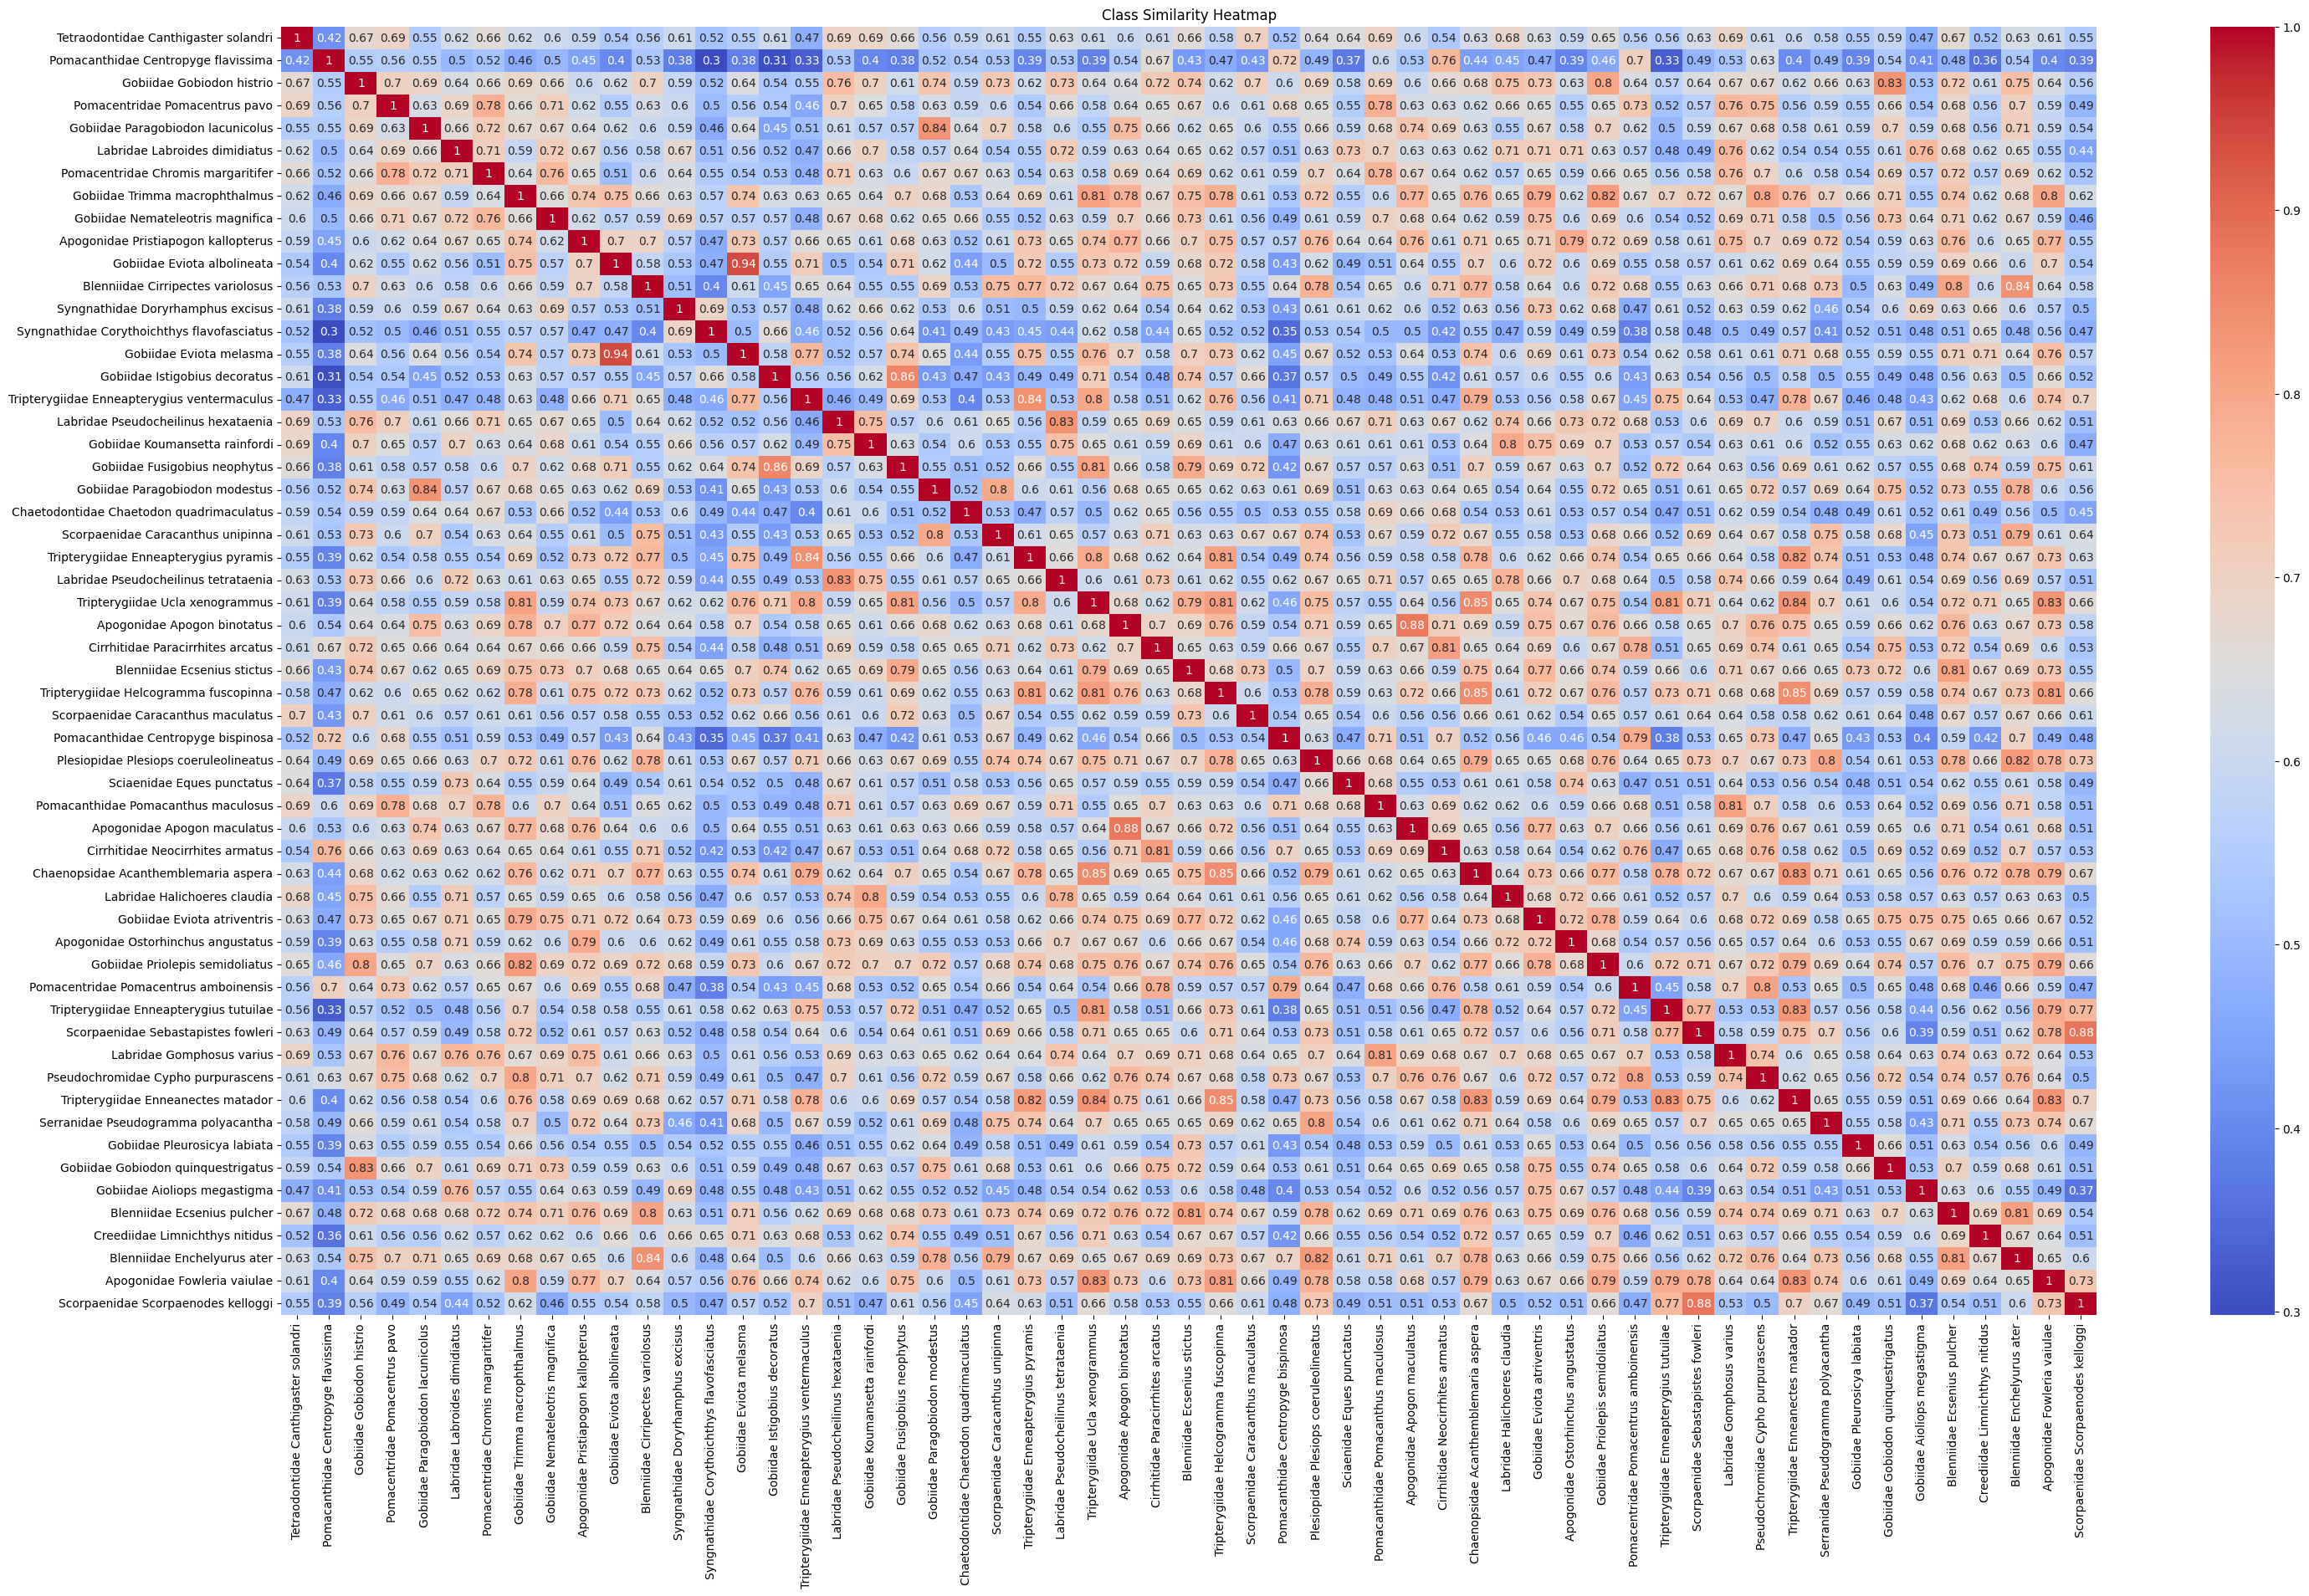

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(35, 20))
sns.heatmap(df_similarity, annot=True, cmap='coolwarm')
plt.title('Class Similarity Heatmap')
plt.show()


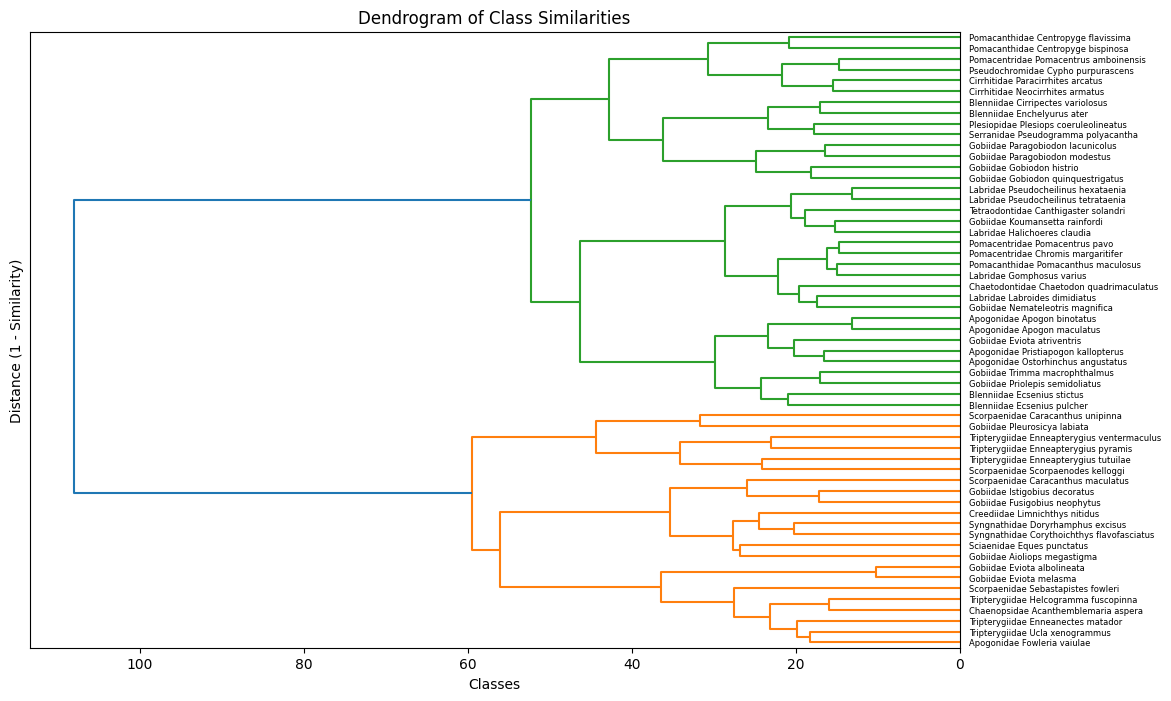

In [68]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - similarity_matrix

# Perform hierarchical clustering
linked = linkage(distance_matrix, method='ward')

# Plot Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linked,
    orientation='left',
    labels=class_names,
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrogram of Class Similarities')
plt.xlabel('Classes')
plt.ylabel('Distance (1 - Similarity)')
plt.show()


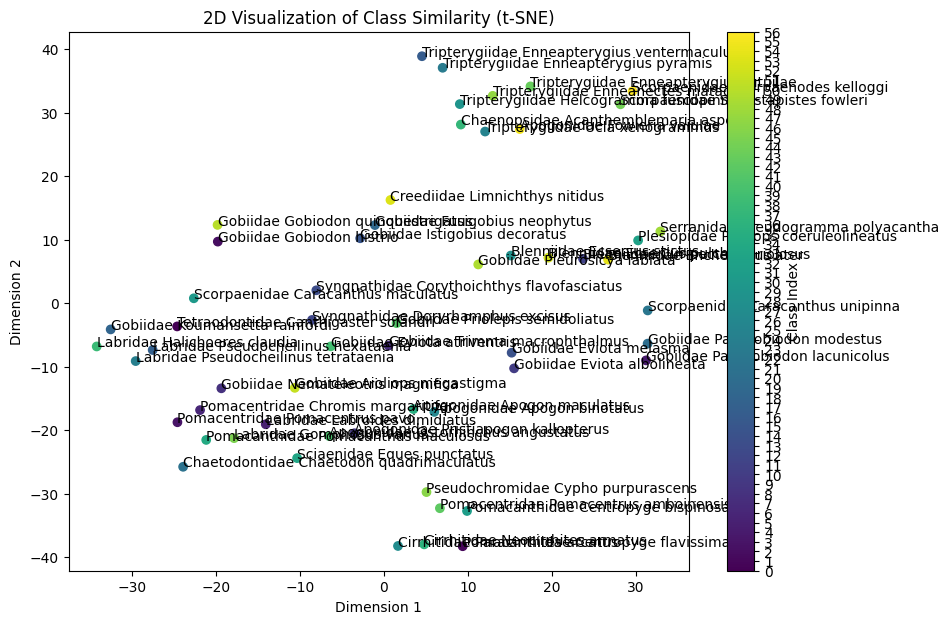

In [79]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Apply Dimensionality Reduction (Choose t-SNE or PCA)
def reduce_dimensions(feature_matrix, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=5)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method should be 'tsne' or 'pca'")
    
    reduced_features = reducer.fit_transform(feature_matrix)
    return reduced_features

# 2. Reduce Feature Dimensions
reduced_data = reduce_dimensions(feature_matrix, method='tsne')

# 3. Plot 2D Visualization of Class Similarity
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=np.arange(len(class_names)), cmap='viridis')
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class Index')
plt.title('2D Visualization of Class Similarity (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Annotate points with class names
for i, class_name in enumerate(class_names):
    plt.annotate(class_name, (reduced_data[i, 0], reduced_data[i, 1]))

plt.show()


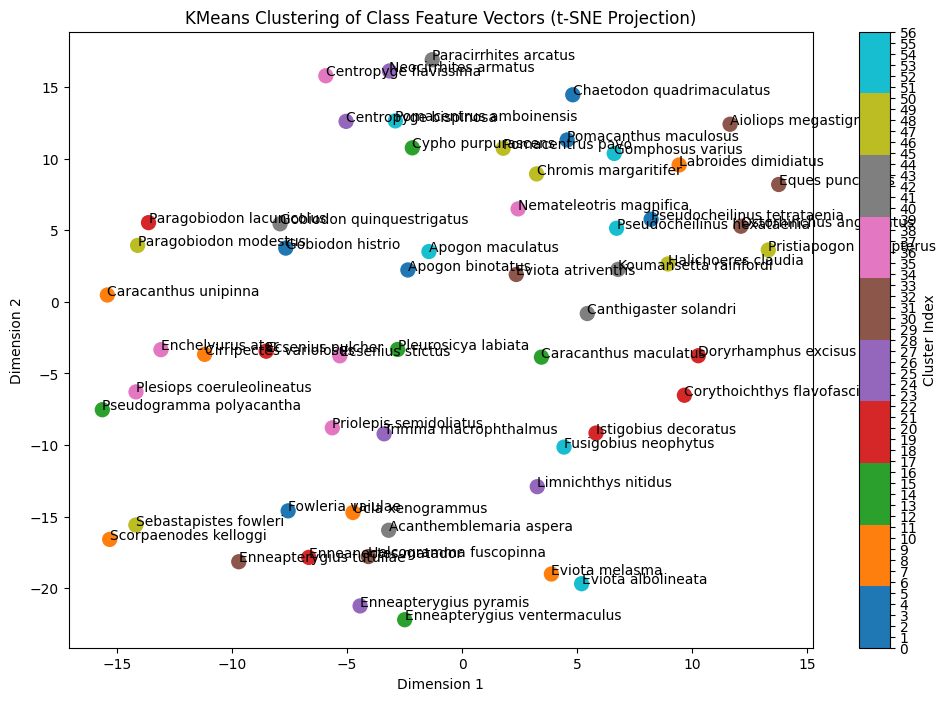

In [57]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Perform KMeans Clustering
def perform_kmeans(feature_matrix, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(feature_matrix)
    return cluster_labels, kmeans

# 2. Apply Dimensionality Reduction (t-SNE)
def reduce_dimensions(feature_matrix):
    reducer = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_features = reducer.fit_transform(feature_matrix)
    return reduced_features

# 3. Cluster and Visualize
n_clusters = 57  # Adjust based on the number of clusters you expect
cluster_labels, kmeans = perform_kmeans(feature_matrix, n_clusters=n_clusters)
reduced_data = reduce_dimensions(feature_matrix)

# 4. Plot 2D Clustering Visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab10', s=100)
plt.colorbar(scatter, ticks=range(n_clusters), label='Cluster Index')
plt.title('KMeans Clustering of Class Feature Vectors (t-SNE Projection)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Annotate class names on the plot
for i, class_name in enumerate(class_names):
    plt.annotate(class_name, (reduced_data[i, 0], reduced_data[i, 1]))

plt.show()


/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_84498/2549553581.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='single')  # Ward's method for clustering


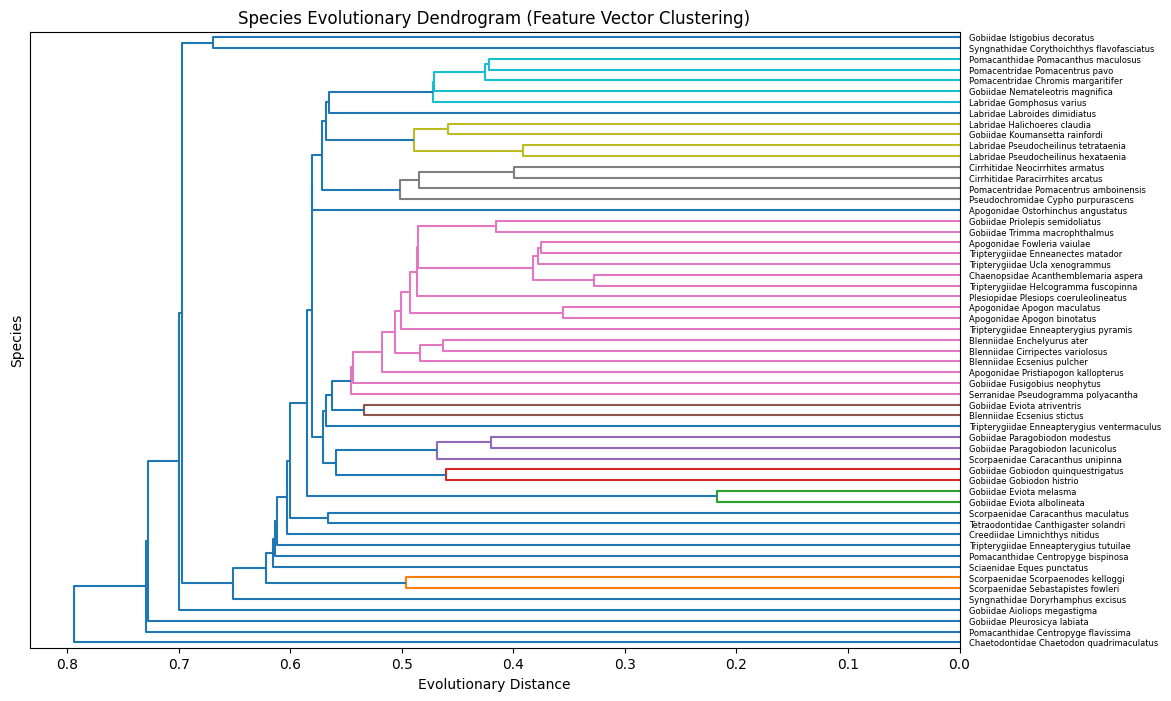

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import numpy as np

# 1. Compute Class-Level Feature Vectors
class_avg_features = {
    cls: np.mean(features, axis=0) for cls, features in class_features.items()
}

class_names = list(class_avg_features.keys())
feature_matrix = np.array([class_avg_features[cls] for cls in class_names])

# 2. Compute Distance Matrix (Cosine or Euclidean)
distance_matrix = cosine_distances(feature_matrix)  # Cosine distance

# 3. Perform Hierarchical Clustering
linked = linkage(distance_matrix, method='single')  # Ward's method for clustering

# 4. Plot Horizontal Dendrogram (Evolutionary Representation)
plt.figure(figsize=(12, 8))
dendrogram(
    linked,
    orientation='left',  # Horizontal dendrogram
    labels=class_names,
    distance_sort='ascending',
    show_leaf_counts=True
)
plt.title('Species Evolutionary Dendrogram (Feature Vector Clustering)')
plt.xlabel('Evolutionary Distance')
plt.ylabel('Species')
plt.show()
